# Working with Unlabeled Data – Clustering Analysis

In the previous section, we used supervised learning techniques to build machine learning models using data where the answer was already known—the class labels were already available in our training data. In this section, we will switch gears and explore cluster analysis.  The goal of clustering is to find a natural grouping in data so that items in the same cluster are more similar to each other than to those from different clusters.

## Grouping objects by similarity

**k-means**, which is widely used in academia as well as in industry. Clustering (or cluster analysis) is a technique that allows us to find groups of similar objects, objects that are more related to each other than to objects in other groups. Examples of business-oriented applications of clustering include the grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines.

### K-means

The k-means algorithm belongs to the category of **prototype-based clustering**.  Prototype-based clustering means that each cluster is represented by a prototype, which can either be the centroid (average) of similar points with continuous features, or the medoid (the most representative or most frequently occurring point) in the case of categorical features. While k-means is very good at identifying clusters with a spherical shape, one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters, **k, a priori**. An inappropriate choice for k can result in poor clustering performance.

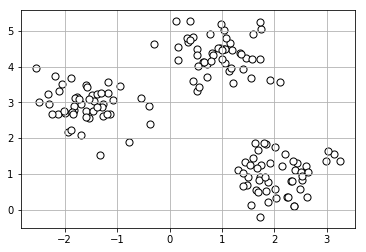

In [2]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=150,
                 n_features=2,
                 centers=3,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=0)

plt.scatter(X[:, 0],
           X[:, 1],
           c='white',
           marker='o',
           edgecolor='black',
           s=50)

plt.grid()
plt.show()

The k-means algorithm that can be summarized by the following four steps:

1. Randomly pick k centroids from the sample points as initial cluster centers.
2. Assign each sample to the nearest centroid $\mu^{(j)}, j \in \left\{ 1, \dots, k \right\}$
3. Move the centroids to the center of the samples that were assigned to it.
4. Repeat steps 2 and 3 until the cluster assignments do not change or a user-defined tolerance or maximum number of iterations is reached.

Now, the next question is **how do we measure similarity between objects?** We can define similarity as the opposite of distance, and a commonly used distance for clustering samples with continuous features is the squared Euclidean distance between two points x and y in m-dimensional space:

\begin{equation*}
d \left( x, y \right)^2 = \sum_{j=1}^m \left( x_j - y_j \right)^2 = \| x-y \|^2_2
\end{equation*}

> Note that, in the preceding equation, the index $j$ refers to the jth dimension (feature column) of the sample points $x$ and $y$. In the rest of this section, we will use the superscripts $i$ and $j$ to refer to the sample index and cluster index, respectively.

Based on this Euclidean distance metric, we can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster **Sum of Squared Errors (SSE)**, which is sometimes also called **cluster inertia**:

\begin{equation*}
SSE = \sum_{i=1}^n \sum_{j=1}^k w^{(i, j)} \| x^{(i)} - \mu^{(j)} \|^2_2
\end{equation*}

Here $\mu^{(j)}$ is the representative point (centroid) for cluster $j$, and $w^{(i, j)}=1$ if the sample $x^{(i)}$ is in cluster $j$; $w^{(i, j)} = 0$ otherwise.

In [7]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
           init='random',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

y_km = km.fit_predict(X)

A problem with k-means is that one or more clusters can be empty. However, this problem is accounted for in the current k-means implementation in scikit-learn. If a cluster is empty, the algorithm will search for the sample that is farthest away from the centroid of the empty cluster. Then it will reassign the centroid to be this farthest point.

Let's now visualize the clusters that k-means identified in the dataset together with the cluster centroids. These are stored under the cluster\_centers\_ attribute of the fitted KMeans object:

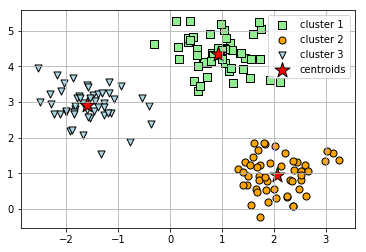

In [8]:
plt.scatter(X[y_km == 0, 0],
           X[y_km == 0, 1],
           s=50, c='lightgreen',
           marker='s', edgecolor='black',
           label='cluster 1')

plt.scatter(X[y_km == 1, 0],
           X[y_km == 1, 1],
           s=50, c='orange',
           marker='o', edgecolor='black',
           label='cluster 2')

plt.scatter(X[y_km == 2, 0],
           X[y_km == 2, 1],
           s=50, c='lightblue',
           marker='v', edgecolor='black',
           label='cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
           km.cluster_centers_[:, 1],
           s=250, marker='*',
           c='red', edgecolor='black',
           label='centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Although k-means worked well on this toy dataset, we shall highlight another drawback of k-means: we have to specify the number of clusters, **k, a priori**. The number of clusters to choose may not always be so obvious in real-world applications, especially if we are working with a higher dimensional dataset that cannot be visualized. The other properties of k-means are that clusters do not overlap and are not hierarchical, and we also assume that there is at least one item in each cluster.

### k-means++

K-means++ strategy is to place the initial centroids far away from each other, to deal with the problem of the initial centroids. The initialization in k-means++ can be summarized as follows:

  1. Initialize an empty set $M$ to store the $k$ centroids being selected.
  2. Randomly choose the first centroid $\mu^{(j)}$ from the input samples and assign it to $M$.
  3. For each sample $x^{(i)}$ that is not in $M$, find the minimum squared distance $d \left( x^{(i)}, M \right)^2$ to any of the centroids in $M$.
  4. To randomly select the next centroid $\mu^{(p)}$, use a weighted probability distribution equal to $ \frac{d \left( \mu^{(p)}, M \right)^2}{\sum_i d \left( x^{(i)}, M \right)^2}$
  5. Repeat steps 2 and 3 until $k$ centroids are chosen.
  6. Proceed with the classic k-means algorithm.
  
To use k-means++ with scikit-learn's KMeans object, we just need to set the init parameter to 'k-means++'. In fact, 'k-means++' is the default argument to the init parameter, which is strongly recommended in practice. 

## Hard versus soft clustering

**Hard clustering** describes a family of algorithms where each sample in a dataset is assigned to exactly one cluster, as in the k-means algorithm that we discussed in the previous subsection. In contrast, algorithms for **soft clustering** (sometimes also called *fuzzy clustering*) assign a sample to one or more clusters. A popular example of soft clustering is the **fuzzy C-means (FCM)** algorithm (also called soft k-means or fuzzy k-means).

The FCM procedure is very similar to k-means. However, we replace the hard cluster assignment with probabilities for each point belonging to each cluster. In k-means, we could express the cluster membership of a sample x with a sparse vector of binary values:

\begin{bmatrix}
\mu^{(1)} \rightarrow 0 \\
\mu^{(2)} \rightarrow 1 \\
\mu^{(3)} \rightarrow 0 \\
\end{bmatrix}

Here, the index position with value 1 indicates the cluster centroid $\mu^{(j)}$  the sample is assigned to (assuming $k=3, j\in \{1, 2, 3 \}$ ). In contrast, a membership vector in FCM could be represented as follows:

\begin{bmatrix}
\mu^{(1)} \rightarrow 0.10 \\
\mu^{(2)} \rightarrow 0.85 \\
\mu^{(3)} \rightarrow 0.05 \\
\end{bmatrix}

Here, each value falls in the range $[0, 1]$ and represents a probability of membership of the respective cluster centroid. The sum of the memberships for a given sample is equal to 1. 

Similar to the k-means algorithm, we can summarize the FCM algorithm in four key steps:

  1. Specify the number of $k$ centroids and randomly assign the cluster memberships for each point.
  2. Compute the cluster centroids $\mu^{(j)}, j \in \{1, \dots, k\}$.
  3. Update the cluster memberships for each point.
  4. Repeat steps 2 and 3 until the membership coefficients do not change, or a user-defined tolerance or maximum number of iterations is reached.
  
The objective function of FCM—we abbreviate it as $J_m$ —looks very similar to the within cluster sum-squared-error that we minimize in k-means:

\begin{equation*}
J_m = \sum_{i=1}^m \sum_{j=1}^k w^{m(i, j)} \| x^{(i)} - \mu^{(j)} \|^2_2
\end{equation*}

Note that the membership indicator $w^{(i, j)}$  is not a binary value as in k-means ($w^{(i, j)} \in \{0, 1 \}$), but a real value that denotes the cluster membership probability $\left( w^{(i, j)} \in [0, 1] \right)$. You also may have noticed that we added an additional exponent to $w^{(i, j)}$; the exponent $m$, any number greater than or equal to one (typically $m=2$), is the so-called **fuzziness coefficient** (or simply fuzzifier) that controls the degree of **fuzziness**. The larger the value of $m$ the smaller the cluster membership $w^{(i ,j)}$ becomes, which leads to fuzzier clusters. The cluster membership probability itself is calculated as follows:

\begin{equation*}
w^{(i, j)} = \left[ \sum_{p=1}^k \left( \frac{\| x^{(i)} - \mu^{(j)} \|_2}{\| x^{(i)} - \mu^{(p)} \|_2} \right)^{\frac{2}{m-1}} \right]^{-1}
\end{equation*}

For example, if we chose three cluster centers as in the previous k-means example, we could calculate the membership of the $x^{(i)}$  sample belonging to the $\mu^{(j)}$ cluster as follows:

\begin{equation*}
w^{(i, j)} = \left[ \left( \frac{ \| x^{(i)} - \mu^{(j)} \|_2}{ \| x^{(i)} - \mu^{(1)} \|_2} \right)^{\frac{2}{m-1}} + \left( \frac{ \| x^{(i)} - \mu^{(j)} \|_2}{ \| x^{(i)} - \mu^{(2)} \|_2} \right)^{\frac{2}{m-1}} + \left( \frac{ \| x^{(i)} - \mu^{(j)} \|_2}{ \| x^{(i)} - \mu^{(3)} \|_2} \right)^{\frac{2}{m-1}} \right]^{-1}
\end{equation*}

The center $\mu^{(j)}$ of a cluster itself is calculated as the mean of all samples weighted by the degree to which each sample belongs to that cluster ($w^{m(i, j)}$):


\begin{equation*}
\mu^{(j)} = \frac{\sum_{i=1}^n w^{m(i, j)}x^{(i)}}{\sum_{i=1}^n w^{m(i, j)}}
\end{equation*}

Just by looking at the equation to calculate the cluster memberships, it is intuitive to say that each iteration in FCM is more expensive than an iteration in k-means. However, FCM typically requires fewer iterations overall to reach convergence. Unfortunately, the FCM algorithm is currently not implemented in scikit-learn. 

## Using the elbow method to find the optimal number of clusters

In unsupervised learning We don't have the ground truth class labels in our dataset that allow us to apply the techniques that we have used. Thus, to quantify the quality of clustering, we need to use intrinsic metrics to compare the performance of different k-means clusterings. Conveniently, we don't need to compute the within-cluster SSE explicitly when we are using scikit-learn, as it is already accessible via the `inertia_` attribute after fitting a KMeans model: 

In [5]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


Based on the within-cluster SSE, we can use a graphical tool, the so-called **elbow method**, to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the distortion will decrease. This is because the samples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly, which will become clearer if we plot the distortion for different values of k:

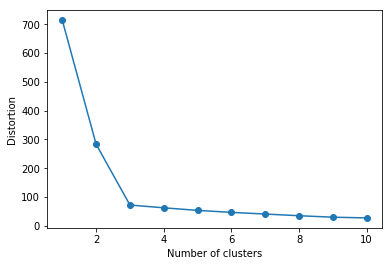

In [6]:
distortions = []

for i in range(1, 11):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see in the following plot, the elbow is located at $k=3$, which is evidence that $k=3$ is indeed a good choice for this dataset.

## Quantifying the quality of clustering via silhouette plots

Another intrinsic metric to evaluate the quality of a clustering is silhouette analysis, which can also be applied to clustering algorithms. Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the samples in the clusters are. To calculate the silhouette coefficient of a single sample in our dataset, we can apply the following three steps:

  1. Calculate the cluster cohesion $a^{(i)}$ as the average distance between a sample $x^{(i)}$ and all other points in the same cluster.
  2. Calculate the cluster separation $b^{(i)}$ from the next closest cluster as the average distance between the sample $x^{(i)}$ and all samples in the nearest cluster.
  3. Calculate the silhouette $s^{(i)}$ as the difference between cluster cohesion and separation divided by the greater of the two, as shown here:
  \begin{equation*}
  s^{(i)} = \frac{b^{(i)} - a^{(i)}}{\max \left\{ b^{(i)}, a^{(i)} \right\}}
  \end{equation*}

The silhouette coefficient is bounded in the range -1 to 1. Based on the preceding equation, we can see that the silhouette coefficient is $0$ if the cluster separation and cohesion are equal ($b^{(i)} = a^{(i)}$). Furthermore, we get close to an ideal silhouette coefficient of $1$ if $b^{(i)} \gg a^{(i)}$, since $b^{(i)}$ quantifies how dissimilar a sample is to other clusters, and $a^{(i)}$  tells us how similar it is to the other samples in its own cluster.

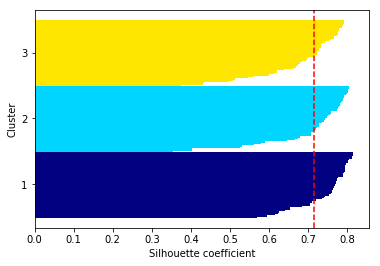

In [8]:
# plot of the silhouette coefficient for a k-means clustering with k=3
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples


km = KMeans(n_clusters=3,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
           color="red",
           linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

Through a visual inspection of the silhouette plot, we can quickly scrutinize the sizes of the different clusters and identify clusters that contain outliers.

However, as we can see in the preceding silhouette plot, the silhouette coefficients are not even close to 0, which is in this case an indicator of a **good** clustering. Furthermore, to summarize the goodness of our clustering, we added the average silhouette coefficient to the plot (dotted line).

To see what a silhouette plot looks like for a relatively bad clustering, let's seed the k-means algorithm with only two centroids:

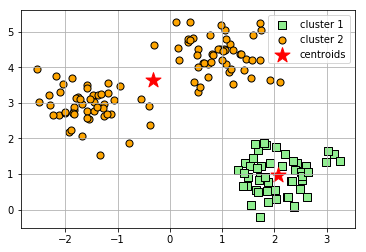

In [9]:
km = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
           X[y_km == 0, 1],
           s=50, c='lightgreen',
           edgecolor='black',
           marker='s',
           label='cluster 1')

plt.scatter(X[y_km == 1, 0],
           X[y_km == 1, 1],
           s=50,
           c='orange',
           edgecolor='black',
           marker='o',
           label='cluster 2')
plt.scatter(km.cluster_centers_[:, 0],
           km.cluster_centers_[:, 1],
           s=250,
           marker='*',
           c='red',
           label='centroids')

plt.legend()
plt.grid()
plt.show()

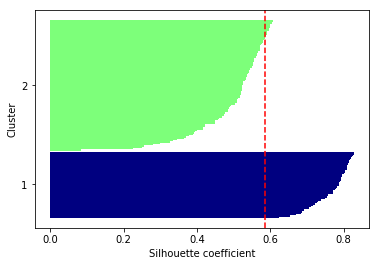

In [10]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()